# Eve of Extinction

This notebook documents our attempt to model species' extinction/endangerment ratings, on a 0-5 scale based on IUCN extinction/endangerment ratings. We use various SKLearn-based classification models to build classifiers to do this.

We've engineered features based on a species' taxonomy, namely its class, as well as the species' physical locations, taking a look at its country's enviornmental record. We explore the combination of these two domains into single interaction features, to see if this type of aggregation is a valid technique of feature engineering and modeling.

### Import packages

In [165]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report, precision_score, recall_score, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
import xgboost as xgb
import pickle

# Data Cleaning

Data was scraped from the IUCN Red List, a tracker of endangered/extinct species. We collected data for species in eight countries.

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df.shape

(17800, 14)

In [4]:
# rename column and drop superfluous columns
df.rename(columns={'c_lass':'class'},inplace=True)
df_eda = df.drop(['family', 'year', 'criteria', 'justification', 'assessors', 'affil', 'order', 'kingdom'], axis=1)

In [5]:
# only keep rows with a valid extinction/endangerment status
df_eda = df_eda.loc[(df_eda['reg_stat'] == 'Vulnerable') |
           (df_eda['reg_stat'] == 'Least Concern') | (df_eda['reg_stat'] == 'Endangered') | 
           (df_eda['reg_stat'] == 'Near Threatened') | (df_eda['reg_stat'] == 'Critically Endangered') | 
           (df_eda['reg_stat'] == 'Extinct') | (df_eda['reg_stat'] == 'Regionally Extinct')]

In [7]:
df_eda['reg_stat'].replace(['Data Deficient ', 'Vulnerable', 'Least Concern', 'Endangered', 'Near Threatened',
                           'Critically Endangered', 'Extinct', 'Regionally Extinct'],
                           ['DD',2,0,3,1,4,5,5],inplace=True)
df_eda['reg_stat'] = df_eda['reg_stat'].astype(int)

For the purposes of analysis, we only keep classes with greater than 50 unique species.

In [8]:
s = df_eda['class'].value_counts()
df_eda = df_eda[df_eda.isin(s.index[s >= 50]).values]

# EDA

We visualize the overall amount of endagerment/extinction status, as well as status per species class.

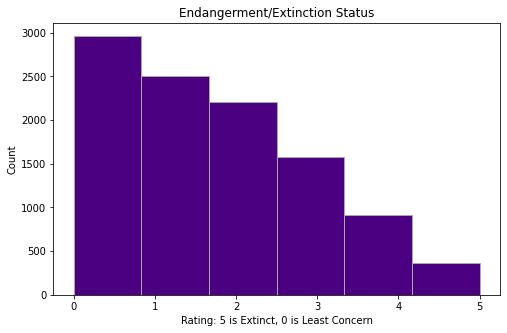

In [183]:
fig = plt.figure(figsize = (8,5))
ax = fig.gca()
ax.hist(df_eda['reg_stat'], edgecolor = 'darkgrey', color ='indigo', bins = 6)
ax.set_title('Endangerment/Extinction Status')
ax.set_xlabel('Rating: 5 is Extinct, 0 is Least Concern')
ax.set_ylabel('Count')
plt.show()

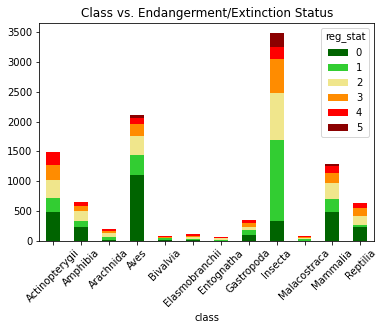

In [120]:
group_class = df_eda.groupby(['class','reg_stat'])['class'].count().unstack()
group_class.plot(kind = 'bar', stacked = True, color = ['darkgreen', 'limegreen', 'khaki', 'darkorange', 'red', 'darkred'])
ax = plt.gca()
ax.set_title('Class vs. Endangerment/Extinction Status')
plt.xticks(rotation=45)
plt.show()

# Feature Engineering

We engineered features on both the species' countries and the species' (taxonomical) families. We then tried to combine these sets of features into interactions.

In [17]:
df_fe = df_eda.copy()

## Country FE

We visualize extinction/endangerment status per country.

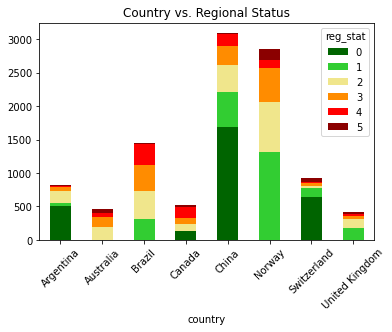

In [128]:
group_country = df_fe.groupby(['country','reg_stat'])['country'].count().unstack()
group_country.plot(kind = 'bar', stacked = True, color = ['darkgreen', 'limegreen', 'khaki', 'darkorange', 'red', 'darkred'])
ax = plt.gca()
ax.set_title('Country vs. Regional Status')
plt.xticks(rotation=45)
plt.show()

For each species' particular country, we add three data points:
* commitment_rating: IUCN rating for a country's commitment toward its voluntary pledges toward the Paris Agreement, an attempt to keep global temperatures 1.5 degrees Celsius below pre-industrial levels; higher is better
* emissions: carbon emissions per land area, measured in megaton per square kilometer; lower is better
* forest_land_area_index: measure of forest land area as a percentage of 1990 levels; higher is better, but this will be reversed later

In [18]:
countries = {
    'Argentina' : {'commitment_rating' : 1, 'emissions' : 482080/2780400,
                   'forest_land_area_index' : 0.78},
    'Brazil' : {'commitment_rating' : 2, 'emissions' : 1379380/8500000, 
                  'forest_land_area_index' : 0.90},
    'Australia' : {'commitment_rating' : 2, 'emissions' : 584850/7617930,
                   'forest_land_area_index' : 0.97},
    'Canada' : {'commitment_rating' : 2, 'emissions' : 779270/9984670,
                   'forest_land_area_index' : 0.99},
    'China' : {'commitment_rating' : 1, 'emissions' : 11886860/9600000,
                   'forest_land_area_index' : 1.33},
    'Norway' : {'commitment_rating' : 2, 'emissions' : 46760/385203,
                   'forest_land_area_index' : 1.00},
    'Switzerland' : {'commitment_rating' : 2, 'emissions' : 48260/41285,
                   'forest_land_area_index' : 1.09},
    'United Kingdom' : {'commitment_rating' : 2, 'emissions' : 474310/242500,
                   'forest_land_area_index' : 1.13}
}

In [19]:
for country in countries:
    condition = df_fe['country'] == country
    df_fe.loc[condition, 'commitment_rating'] = countries[country]['commitment_rating']
    df_fe.loc[condition, 'emissions'] = countries[country]['emissions']
    df_fe.loc[condition, 'forest_land_area_index'] = countries[country]['forest_land_area_index']

df_fe['commitment_rating'] = df_fe['commitment_rating'].astype(int)

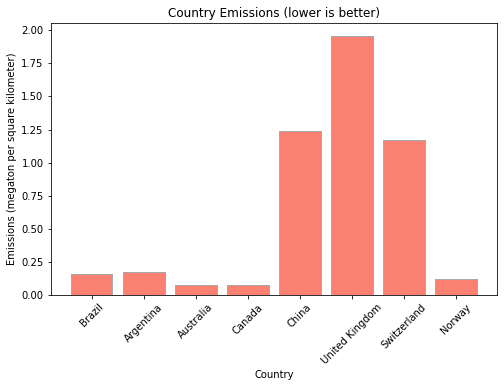

In [145]:
fig = plt.figure(figsize = (8,5))
ax = fig.gca()
ax.bar(df_fe['country'], df_fe['emissions'], edgecolor = 'darkgrey', color = 'salmon')
ax.set_title('Country Emissions (lower is better)')
ax.set_xlabel('Country')
ax.set_ylabel('Emissions (megaton per square kilometer)')
plt.xticks(rotation=45)
plt.show()

To have the 'forest_land_area_index' feature comparable to 'emissions' and correlate in the same direction, we convert it to a measure of deforestation.

In [21]:
df_fe['desforesation'] = 1 - df_fe['forest_land_area_index']
df_fe.drop('forest_land_area_index', axis = 1, inplace = True)

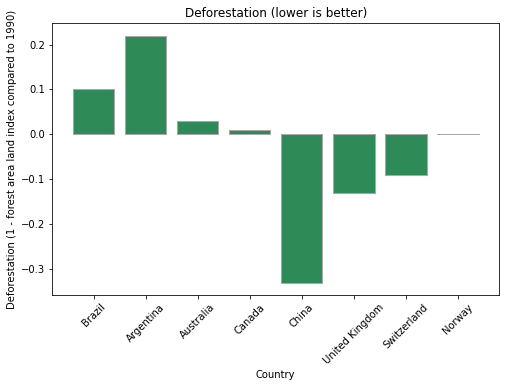

In [146]:
fig = plt.figure(figsize = (8,5))
ax = fig.gca()
ax.bar(df_fe['country'], df_fe['desforesation'], edgecolor = 'darkgrey', color = 'seagreen')
ax.set_title('Deforestation (lower is better)')
ax.set_xlabel('Country')
ax.set_ylabel('Deforestation (1 - forest area land index compared to 1990)')
plt.xticks(rotation=45)
plt.show()

## Class FE

For each of the 12 classes, we define their depenence on forest lands, as well as vulnerability to rising carbon emissions.

In [23]:
classes = {
    'Insecta' : {'forest_dependence' : 2, 'emission_vulnerability' : 2},
    'Aves' : {'forest_dependence' : 3, 'emission_vulnerability' : 2},
    'Actinopterygii' : {'forest_dependence' : 0, 'emission_vulnerability' : 3},
    'Mammalia' : {'forest_dependence' : 1, 'emission_vulnerability' : 1},
    'Amphibia' : {'forest_dependence' : 2, 'emission_vulnerability' : 0},
    'Reptilia' : {'forest_dependence' : 1, 'emission_vulnerability' : 0},
    'Gastropoda' : {'forest_dependence' : 1, 'emission_vulnerability' : 0},
    'Arachnida' : {'forest_dependence' : 1, 'emission_vulnerability' : 0},
    'Elasmobranchii' : {'forest_dependence' : 0, 'emission_vulnerability' : 3},
    'Bivalvia' : {'forest_dependence' : 0, 'emission_vulnerability' : 3},
    'Malacostraca' : {'forest_dependence' : 1, 'emission_vulnerability' : 2},
    'Entognatha' : {'forest_dependence' : 2, 'emission_vulnerability' : 2}
}

In [24]:
for class_ in df_fe['class']:
    condition = df_fe['class'] == class_
    df_fe.loc[condition, 'forest_dependence'] = classes[class_]['forest_dependence']
    df_fe.loc[condition, 'emission_vulnerability'] = classes[class_]['emission_vulnerability']

In [25]:
df_fe['forest_dependence'] = df_fe['forest_dependence'].astype(int)
df_fe['emission_vulnerability'] = df_fe['emission_vulnerability'].astype(int)

## Class x Country FE

Finally, we attempt to combine country features and class features into interactions. For each species, we multiply its country's carbon emissions by its class' carbon vulnerability, and its country's deforestation by its class's forest dependence.

In [28]:
df_fe['class_country_emis'] = df_fe['emission_vulnerability'] * df_fe['emissions']
df_fe['class_country_fore'] = df_fe['forest_dependence'] * df_fe['desforesation']

In [45]:
df_fe.head()

,country,phylum,class,genus,species,reg_stat,commitment_rating,emissions,desforesation,forest_dependence,emission_vulnerability,class_country_emis,class_country_fore
0,Brazil,Chordata,Aves,Anodorhynchus,glaucus,5,2,0.16228,0.1,3,2,0.32456,0.3
1,Brazil,Chordata,Elasmobranchii,Carcharhinus,isodon,5,2,0.16228,0.1,0,3,0.48684,0.0
2,Brazil,Chordata,Aves,Cichlocolaptes,mazarbarnetti,5,2,0.16228,0.1,3,2,0.32456,0.3
3,Brazil,Chordata,Aves,Glaucidium,mooreorum,5,2,0.16228,0.1,3,2,0.32456,0.3
4,Brazil,Chordata,Mammalia,Noronhomys,vespuccii,5,2,0.16228,0.1,1,1,0.16228,0.1


# Feature Selection

Next, we conduct feature selection. We have relatively few features, but the big question is whether we want to keep the country features and family features independent, or combine them and use the interactions. We'll work with two separate dataframes and conduct a GridSearch to find the most important features in each.

In [64]:
df_fs = df_fe.copy()

We drop the country, genus, and species columns, and create dummies for the phylum (3 values) and class (12 values) columns.

In [65]:
df_fs.drop(['country', 'genus', 'species'], axis=1, inplace = True)
df_fs = pd.get_dummies(df_fs, columns=['phylum', 'class'], drop_first=True)

In [67]:
df_fs_indep = df_fs.copy()
df_fs_inter = df_fs.copy()

In [68]:
df_fs_indep.drop(['class_country_emis', 'class_country_fore'], axis=1, inplace = True)
df_fs_inter.drop(['emissions', 'desforesation', 'emission_vulnerability', 'forest_dependence'], axis=1, inplace = True)

In [69]:
df_fs_indep.head(2)

,reg_stat,commitment_rating,emissions,desforesation,forest_dependence,emission_vulnerability,phylum_Chordata,phylum_Mollusca,class_Amphibia,class_Arachnida,class_Aves,class_Bivalvia,class_Elasmobranchii,class_Entognatha,class_Gastropoda,class_Insecta,class_Malacostraca,class_Mammalia,class_Reptilia
0,5,2,0.16228,0.1,3,2,1,0,0,0,1,0,0,0,0,0,0,0,0
1,5,2,0.16228,0.1,0,3,1,0,0,0,0,0,1,0,0,0,0,0,0


In [70]:
df_fs_inter.head(2)

,reg_stat,commitment_rating,class_country_emis,class_country_fore,phylum_Chordata,phylum_Mollusca,class_Amphibia,class_Arachnida,class_Aves,class_Bivalvia,class_Elasmobranchii,class_Entognatha,class_Gastropoda,class_Insecta,class_Malacostraca,class_Mammalia,class_Reptilia
0,5,2,0.32456,0.3,1,0,0,0,1,0,0,0,0,0,0,0,0
1,5,2,0.48684,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0


The below function takes in a dataframe and runs a Random Forest GridSearch to find the best estimator. With the best estimator, we can plot the most important features.

In [72]:
def calculate_feature_importances(dataframe):
    y = dataframe['reg_stat']
    X = dataframe.drop('reg_stat', axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 88)

    fs_param_grid = {
    'n_estimators': [10, 30, 50],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [None, 3, 6, 8],
    'min_samples_split' : [3, 5, 10],
    'min_samples_leaf': [3, 6, 9]}
    
    rf_clf = RandomForestClassifier()
    rf_grid_search = GridSearchCV(rf_clf, fs_param_grid, cv = 3)
    rf_grid_search.fit(X_train, y_train)

    rf_best = rf_grid_search.best_estimator_
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), rf_best.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    
    return rf_best

We create new dataframes for this, but keep all dummy columns (drop_first = False). This is so we can see all the class/phlyum columns.

In [180]:
df_fs = df_fe.copy()

df_fs.drop(['country', 'genus', 'species'], axis=1, inplace = True)
df_fs = pd.get_dummies(df_fs, columns=['phylum', 'class'], drop_first = False)

df_best_indep = df_fs.copy()
df_best_inter = df_fs.copy()

df_best_indep.drop(['class_country_emis', 'class_country_fore'], axis=1, inplace = True)
df_best_inter.drop(['emissions', 'desforesation', 'emission_vulnerability', 'forest_dependence'], axis=1, inplace = True)

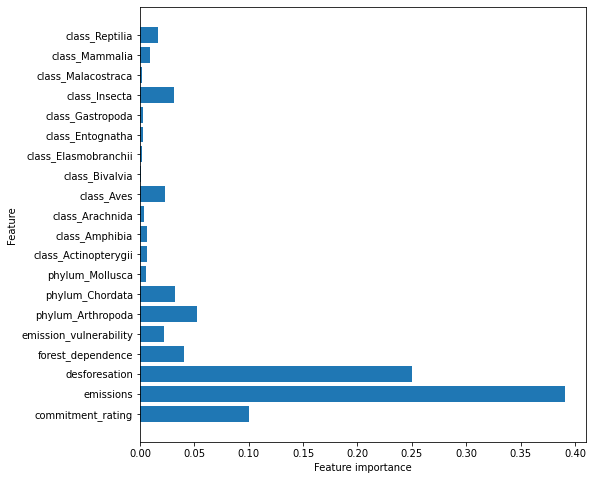

In [181]:
indep_best_estimator = calculate_feature_importances(df_best_indep)

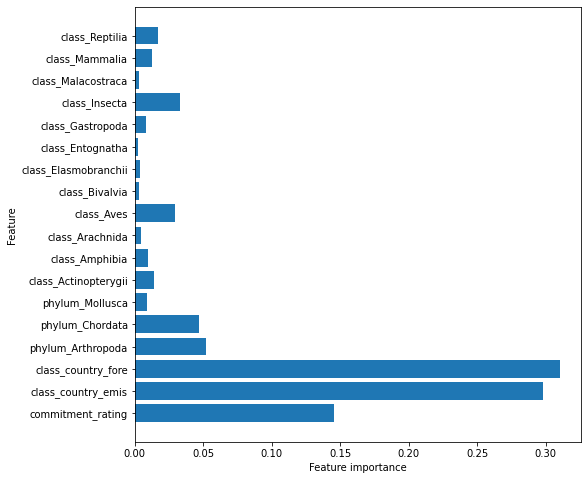

In [182]:
inter_best_estimator = calculate_feature_importances(df_best_inter)

It's still inconclusive whether or not to combine the country x class features, or keep them independent. We'll proceed with both.

# Model Fitting and Hyperparameter Tuning

Since we're unsure to keep the country x class features independent, or combine them as interactions, we try our models with both. We also are wary of possible class imbalance, so we incorporate SMOTE, as well.

We define several functions that will automatically train and test basic models, ensembles, and GridSearches of models and ensembles. Though we will be passing in dataframes with different sets of columns, these functions can accept both, because the target column 'reg_stat' is present in both.

All model variable names will use this covention:
* _1: Country x Class Feature Independence, No SMOTE
* _2: Country x Class Feature Independence, SMOTE
* _3: Country x Class Feature Interaction, No SMOTE
* _4: Country x Class Feature Interaction, SMOTE

In [77]:
df_model_indep = df_fs_indep.copy()
df_model_inter = df_fs_inter.copy()

## Base Models

Basic models for Logistic, K-Nearest Neighbor, and Decision Tree classifiers, as well as their ensemble counterparts.

In [83]:
def train_base_models(dataframe, smote_flag):
    y = dataframe['reg_stat']
    X = dataframe.drop('reg_stat', axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 22)
    if smote_flag == True:
        smote = SMOTE()
        X_train, y_train = smote.fit_sample(X_train, y_train)
    
    
    log_reg = LogisticRegression(fit_intercept = False, C = 1e15, solver = 'liblinear')
    log_reg.fit(X_train, y_train)
    print('Logistic Regression score: ' + str(round(log_reg.score(X_test, y_test), 3)))
    log_reg = LogisticRegression(fit_intercept = False, C = 1e15, solver = 'liblinear')
    log_bag = BaggingClassifier(base_estimator = log_reg, n_estimators = 20)
    log_bag.fit(X_train, y_train)
    print('Bagged Logistic Regression score: ' + str(round(log_bag.score(X_test, y_test), 3)))
    knn_clf = KNeighborsClassifier()
    knn_clf.fit(X_train, y_train)
    print('K-Nearest Neighbors score: ' + str(round(knn_clf.score(X_test, y_test), 3)))
    knn_clf = KNeighborsClassifier()
    knn_bag = BaggingClassifier(base_estimator = knn_clf, n_estimators = 20)
    knn_bag.fit(X_train, y_train)
    print('Bagged K-Nearest Neighbors score: ' + str(round(knn_bag.score(X_test, y_test), 3)))
    dtc_clf = DecisionTreeClassifier()
    dtc_clf.fit(X_train, y_train)
    print('Decision Tree Classifier score: ' + str(round(dtc_clf.score(X_test, y_test), 3)))
    for_clf = RandomForestClassifier(n_estimators = 50, max_depth = 5)
    for_clf.fit(X_train, y_train)
    print('Random Forest score: ' + str(round(for_clf.score(X_test, y_test), 3)))
    
    return log_reg, log_bag, knn_clf, knn_bag, dtc_clf, for_clf

In [92]:
print('Country x Class Feature Independence, no SMOTE\n')
log_reg_1, log_bag_1, knn_clf_1, knn_bag_1, dtc_clf_1, for_clf_1 = train_base_models(df_model_indep, smote_flag = False)

Country x Class Feature Independence, no SMOTE

Logistic Regression score: 0.41
Bagged Logistic Regression score: 0.408
K-Nearest Neighbors score: 0.465
Bagged K-Nearest Neighbors score: 0.478
Decision Tree Classifier score: 0.487
Random Forest score: 0.472


In [93]:
print('Country x Class Feature Independence, SMOTE\n')
log_reg_2, log_bag_2, knn_clf_2, knn_bag_2, dtc_clf_2, for_clf_2 = train_base_models(df_model_indep, smote_flag = True)

Country x Class Feature Independence, SMOTE

Logistic Regression score: 0.286
Bagged Logistic Regression score: 0.286
K-Nearest Neighbors score: 0.412
Bagged K-Nearest Neighbors score: 0.34
Decision Tree Classifier score: 0.366
Random Forest score: 0.355


In [94]:
print('Country x Class Feature Interaction, no SMOTE\n')
log_reg_3, log_bag_3, knn_clf_3, knn_bag_3, dtc_clf_3, for_clf_3 = train_base_models(df_model_inter, smote_flag = False)

Country x Class Feature Interaction, no SMOTE

Logistic Regression score: 0.412
Bagged Logistic Regression score: 0.415
K-Nearest Neighbors score: 0.469
Bagged K-Nearest Neighbors score: 0.482
Decision Tree Classifier score: 0.487
Random Forest score: 0.474


In [95]:
print('Country x Class Feature Interaction, SMOTE\n')
log_reg_4, log_bag_4, knn_clf_4, knn_bag_4, dtc_clf_4, for_clf_4 = train_base_models(df_model_inter, smote_flag = True)

Country x Class Feature Interaction, SMOTE

Logistic Regression score: 0.282
Bagged Logistic Regression score: 0.274
K-Nearest Neighbors score: 0.378
Bagged K-Nearest Neighbors score: 0.358
Decision Tree Classifier score: 0.367
Random Forest score: 0.313


## Advanced Ensembles

Base ensemble models for AdaBoost, Graident Boost, and XGBoost Classifiers.

In [80]:
def train_advanced_ensembles(dataframe, smote_flag):
    y = dataframe['reg_stat']
    X = dataframe.drop('reg_stat', axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 22)
    if smote_flag == True:
        smote = SMOTE()
        X_train, y_train = smote.fit_sample(X_train, y_train)
        
    ada_clf = AdaBoostClassifier()
    ada_clf.fit(X_train, y_train)
    print('Adaboost score: ' + str(round(ada_clf.score(X_test, y_test), 3)))
    gbt_clf = GradientBoostingClassifier()
    gbt_clf.fit(X_train, y_train)
    print('Gradient Boost score: ' + str(round(gbt_clf.score(X_test, y_test), 3)))
    xgb_clf = xgb.XGBClassifier()
    xgb_clf.fit(X_train, y_train)
    print('XGBoost score: ' + str(round(xgb_clf.score(X_test, y_test), 3)))

    return ada_clf, gbt_clf, xgb_clf

In [110]:
print('Country x Class Feature Independence, no SMOTE\n')
ada_clf_1, gbt_clf_1, xgb_clf_1 = train_advanced_ensembles(df_model_indep, smote_flag = False)

Country x Class Feature Independence, no SMOTE

Adaboost score: 0.41
Gradient Boost score: 0.483
XGBoost score: 0.484


In [97]:
print('Country x Class Feature Independence, SMOTE\n')
ada_clf_2, gbt_clf_2, xgb_clf_2 = train_advanced_ensembles(df_model_indep, smote_flag = True)

Country x Class Feature Independence, SMOTE

Adaboost score: 0.285
Gradient Boost score: 0.446
XGBoost score: 0.451


In [98]:
print('Country x Class Feature Interaction, no SMOTE\n')
ada_clf_3, gbt_clf_3, xgb_clf_3 = train_advanced_ensembles(df_model_inter, smote_flag = False)

Country x Class Feature Interaction, no SMOTE

Adaboost score: 0.458
Gradient Boost score: 0.48
XGBoost score: 0.481


In [99]:
print('Country x Class Feature Interaction, SMOTE\n')
ada_clf_4, gbt_clf_4, xgb_clf_4 = train_advanced_ensembles(df_model_inter, smote_flag = True)

Country x Class Feature Interaction, SMOTE

Adaboost score: 0.393
Gradient Boost score: 0.363
XGBoost score: 0.366


## Grid Search with Basic Models

Grid Search on K-Nearest Neighbors and Random Forest.

In [102]:
def train_gridsearch_basic_models(dataframe, smote_flag):
    knn_param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'algorithm' : ['ball_tree', 'kd_tree'],
        'p' : [2, 3, 4]}
    
    rf_param_grid = {
    'n_estimators': [30, 50],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [None, 6, 10],
    'min_samples_split' : [3, 5, 10],
    'min_samples_leaf' : [3, 6, 9],
    'max_features' : [None, 'sqrt', 5]}
    
    y = dataframe['reg_stat']
    X = dataframe.drop('reg_stat', axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 22)
    if smote_flag == True:
        smote = SMOTE()
        X_train, y_train = smote.fit_sample(X_train, y_train)
    
    knn_clf = KNeighborsClassifier()
    knn_grid_search = GridSearchCV(knn_clf, knn_param_grid, cv = 4)
    knn_grid_search.fit(X_train, y_train)
    print('KNN Grid Search score: ' + str(round(knn_grid_search.score(X_test, y_test), 3)))
    rf_clf = RandomForestClassifier()
    rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv = 3)
    rf_grid_search.fit(X_train, y_train)
    print('Random Forest Grid Search score: ' + str(round(rf_grid_search.score(X_test, y_test), 3)))

    return knn_grid_search, rf_grid_search

In [104]:
print('Country x Class Feature Independence, no SMOTE\n')
knn_grid_search_1, rf_grid_search_1 = train_gridsearch_basic_models(df_model_indep, smote_flag = False)

Country x Class Feature Independence, no SMOTE

KNN Grid Search score: 0.469
Random Forest Grid Search score: 0.487


In [105]:
print('Country x Class Feature Independence, SMOTE\n')
knn_grid_search_2, rf_grid_search_2 = train_gridsearch_basic_models(df_model_indep, smote_flag = True)

Country x Class Feature Independence, SMOTE

KNN Grid Search score: 0.45
Random Forest Grid Search score: 0.366


In [107]:
print('Country x Class Feature Interaction, no SMOTE\n')
knn_grid_search_3, rf_grid_search_3 = train_gridsearch_basic_models(df_model_inter, smote_flag = False)

Country x Class Feature Interaction, no SMOTE

KNN Grid Search score: 0.461
Random Forest Grid Search score: 0.48


In [108]:
print('Country x Class Feature Interaction, SMOTE\n')
knn_grid_search_4, rf_grid_search_4 = train_gridsearch_basic_models(df_model_inter, smote_flag = True)

Country x Class Feature Interaction,  SMOTE

KNN Grid Search score: 0.38
Random Forest Grid Search score: 0.366


## Grid Search with Advanced Ensembles

Grid search on Gradient Boost and XGBoost.

In [111]:
def train_gridsearch_advanced_ensembles(dataframe, smote_flag):

    gbt_param_grid = {
        'n_estimators': [30, 50],
        'max_depth' : [None, 6, 10],
        'min_samples_split' : [3, 5, 10],
        'min_samples_leaf' : [3, 6, 9],
        'max_features' : [None, 'sqrt', 5]}
    
    xgb_param_grid = {
        'max_depth':[None, 6, 10],
        'min_child_weight':[4, 6, 8],
        'gamma' : [0, .2, .4]}
    
    y = dataframe['reg_stat']
    X = dataframe.drop('reg_stat', axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 22)
    if smote_flag == True:
        smote = SMOTE()
        X_train, y_train = smote.fit_sample(X_train, y_train)
    
    gbt_clf = GradientBoostingClassifier()
    gbt_grid_search = GridSearchCV(gbt_clf, gbt_param_grid, cv = 3)
    gbt_grid_search.fit(X_train, y_train)
    print('Gradient Boost Grid Search score: ' + str(round(gbt_grid_search.score(X_test, y_test), 3)))
    xgb_clf = xgb.XGBClassifier()
    xgb_grid_search = GridSearchCV(xgb_clf, xgb_param_grid, cv = 3)
    xgb_grid_search.fit(X_train, y_train)
    print('XGBoost Grid Search score: ' + str(round(xgb_grid_search.score(X_test, y_test), 3)))

    return gbt_grid_search, xgb_grid_search

In [112]:
print('Country x Class Feature Independence, no SMOTE\n')
gbt_grid_search_1, xgb_grid_search_1 = train_gridsearch_advanced_ensembles(df_model_indep, smote_flag = False)

Country x Class Feature Independence, no SMOTE

Gradient Boost Grid Search score: 0.487
XGBoost Grid Search score: 0.485


In [113]:
print('Country x Class Feature Independence, SMOTE\n')
gbt_grid_search_2, xgb_grid_search_2 = train_gridsearch_advanced_ensembles(df_model_indep, smote_flag = True)

Country x Class Feature Independence, SMOTE

Gradient Boost Grid Search score: 0.367
XGBoost Grid Search score: 0.367


In [114]:
print('Country x Class Feature Interaction, no SMOTE\n')
gbt_grid_search_3, xgb_grid_search_3 = train_gridsearch_advanced_ensembles(df_model_inter, smote_flag = False)

Country x Class Feature Interaction, no SMOTE

Gradient Boost Grid Search score: 0.486
XGBoost Grid Search score: 0.479


In [115]:
print('Country x Class Feature Interaction, SMOTE\n')
gbt_grid_search_4, xgb_grid_search_4 = train_gridsearch_advanced_ensembles(df_model_inter, smote_flag = True)

Country x Class Feature Interaction, SMOTE

Gradient Boost Grid Search score: 0.364
XGBoost Grid Search score: 0.363


SMOTE led to worse results across the board. Unfortunately, it's still unclear whether holding the country x class features independent or interactive yields better results. We'll conduct detailed evaluation of both. The Gradient Boost Grid Searches yielded the best results, so we'll be taking a look at 'gbt_grid_search_1' and 'gbt_grid_search_3'.

# Model Evaluation

We train and test these models on a train/test split with a NEW random_state. We then make predictions and define a function to generate metrics.

In [152]:
indep_gbt = gbt_grid_search_1
inter_gbt = gbt_grid_search_3

In [177]:
def evaluate_model(true, predictions):
    print('F1 Score: ' + str(round(f1_score(true, predictions, average = 'macro'), 3)))
    print('Precision Score: ' + str(round(precision_score(true, predictions, average = 'macro', zero_division = 1), 3)))
    print('Recall Score: ' + str(round(recall_score(true, predictions, average = 'macro', zero_division = 1), 3)))
    print('Accuracy Score: ' + str(round(accuracy_score(true, predictions), 3)))
    print('\nConfusion Matrix:')
    print(confusion_matrix(true, predictions))

## country x class Independent Model Metrics

In [153]:
indep_gbt.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=None,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=9, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [172]:
y_indep = df_model_indep['reg_stat']
X_indep = df_model_indep.drop('reg_stat', axis = 1)
X_train_indep, X_test_indep, y_train_indep, y_test_indep = train_test_split(X_indep, y_indep, test_size = .2, random_state = 100)
indep_gbt.fit(X_train_indep, y_train_indep)
indep_preds = indep_gbt.predict(X_test_indep)

In [178]:
evaluate_model(y_test_indep, indep_preds)

F1 Score: 0.325
Precision Score: 0.552
Recall Score: 0.346
Accuracy Score: 0.496

Confusion Matrix:
[[563   0  19   0   2   0]
 [140 316  49  18   4   0]
 [118 186  97  37   6   0]
 [ 67 125  39  37  10   0]
 [ 59  54  29  21  31   0]
 [ 16  46  15   1   1   0]]


## country x class Interaction Model Metrics

In [154]:
inter_gbt.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=None,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=9, min_samples_split=3,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [158]:
y_inter = df_model_inter['reg_stat']
X_inter = df_model_inter.drop('reg_stat', axis = 1)
X_train_inter, X_test_inter, y_train_inter, y_test_inter = train_test_split(X_inter, y_inter, test_size = .2, random_state = 100)
inter_gbt.fit(X_train_inter, y_train_inter)
inter_preds = inter_gbt.predict(X_test_inter)

In [179]:
evaluate_model(y_test_inter, inter_preds)

F1 Score: 0.337
Precision Score: 0.562
Recall Score: 0.354
Accuracy Score: 0.5

Confusion Matrix:
[[563   0  19   0   2   0]
 [140 316  45  18   8   0]
 [118 186  97  39   4   0]
 [ 67 125  38  38  10   0]
 [ 59  54  20  21  40   0]
 [ 16  46  15   1   1   0]]


## Model Evaluation Conclusion

Both models performed pretty similarly, neither seemingly having an advantage over the other.

They both had an accuracy of about 50%, though it's worth a reminder that this is a multi-class classification exercise with six classes. The confusion matrix provides a nice overview of how items were (mis-)classed. With a scale of 0-5, 0 being the best ("least concern") and starting in the top-left corner, the majority of misclassifications came below the diagonal, meaning the classifiers were optimistic and ranked species lower than they actually are. This may have been caused by the class imbalance - the histogram of extinction/endangerment ranks skewed toward the lower end of the scale. It's also notable that most misclassifications were only off by 1 - a 1 predicted as a 0, a 2 predicted as a 1, etc.

This exercise experimented with the combination of features from two separate domains: country enviornmentalism and taxonomy-based species vulnerabilities. Further improvements could include the addition of more of these types of interaction-based features, more countries, and/or more species classes.